# Mapa do resultado das Eleições de Deputado Estatudais de 2018 por Zona Eleitoral no distrito de SP

In [ ]:
'''
Fontes:
TSE - zonas eleitorais SP e resultado eleição
http://www.tse.jus.br/eleitor/cartorios-e-zonas-eleitorais/pesquisa-a-zonas-eleitorais
http://agencia.tse.jus.br/estatistica/sead/odsele/votacao_candidato_munzona/votacao_candidato_munzona_2018.zip

Dados Abertos SP - shapefile
http://dados.prefeitura.sp.gov.br/pt_PT/dataset/distritos/resource/9e75c2f7-5729-4398-8a83-b4640f072b5d
https://groups.google.com/forum/#!topic/thackday/oJ-DRcsJL3w
'''

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Obter votos
df_chunk = pd.read_csv('./votos/votacao_candidato_munzona_2018_SP.csv', sep=';', encoding='latin1', chunksize=10000)

In [3]:
cols = ['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_ZONA', 'DS_CARGO',
        'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO', 'SG_PARTIDO', 
        'QT_VOTOS_NOMINAIS']

DS_CARGO = 'Deputado Estadual'

In [4]:
chunk_list = []

# Each chunk is in df format
for chunk in df_chunk:  
    # filtrar somente pelo cargo e colunas desejadas
    chunk_filter = chunk[chunk['DS_CARGO'] == DS_CARGO]
    chunk_filter = chunk_filter[cols]
    
    chunk_list.append(chunk_filter)
    
df_concat = pd.concat(chunk_list)

In [159]:
# Agrupar por zona e candidato
df_zona = df_concat.groupby(['NR_ZONA', 'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS'].sum().reset_index()
df_zona.set_index('NR_ZONA', drop=False, inplace=True)
df_zona.head()

,NR_ZONA,NR_CANDIDATO,NM_URNA_CANDIDATO,NR_PARTIDO,SG_PARTIDO,QT_VOTOS_NOMINAIS
NR_ZONA,,,,,,
1,1,10000,JORGE WILSON XERIFE CONSUMIDOR,10,PRB,730
1,1,10005,ROZANA FIDELES,10,PRB,0
1,1,10012,NANCY,10,PRB,4
1,1,10100,AILDO RODRIGUES,10,PRB,91
1,1,10101,HELIO GODOY,10,PRB,2


In [160]:
# Obter lista de zonas eleitorais do estado de São Paulo
df = pd.read_csv('./votos/lista_zonas_eleitorais.csv', sep=',', encoding='latin1')

In [161]:
# Filtrar somente pela cidade de São Paulo
df_sp = df[df['nome_municipio'] == 'SÃO PAULO']
df_sp.set_index('numero_zona', drop=False, inplace=True)
df_sp.shape

(58, 7)

In [186]:
df_zona_sp = df_zona.join(df_sp)
df_zona_sp.dropna(inplace=True)
df_zona_sp.shape

(118726, 13)

In [189]:
# Definir candidato para analisar
NR_CANDIDATO = 17317
df_zona_sp_cand = df_zona_sp[df_zona_sp['NR_CANDIDATO'] == NR_CANDIDATO]
df_zona_sp_cand.shape

(58, 13)

In [190]:
# Obter shapefile da cidade por zonas eleitorais
df_mapa = gpd.read_file('./geo/Zonas_eleitorais_SP_shp/zonaseleitorais2.shp')
df_mapa['Name'] = df_mapa['Name'].astype(int)
df_mapa.sort_values(by='Name', ascending=True, inplace=True)
df_mapa.set_index('Name', drop=False, inplace=True)
#df_mapa.head()

In [200]:
df_mapa_cand = df_mapa.join(df_zona_sp_cand)
df_mapa_cand.shape

(58, 16)

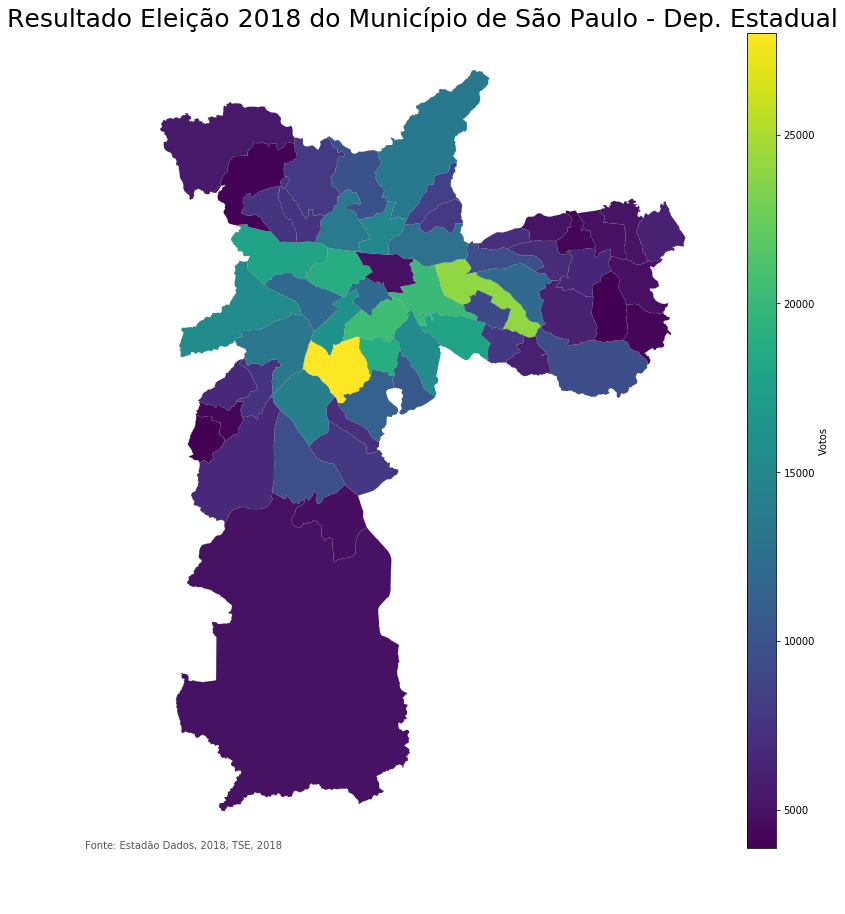

In [235]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(15,15))

df_mapa_cand["center"] = df_mapa_cand["geometry"].centroid
df_points = df_mapa_cand.copy()
df_points.set_geometry("center", inplace = True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

ax = df_mapa_cand.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': 'Votos', 'orientation': 'vertical'}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')

#for x, y, label in zip(df_points.geometry.x, df_points.geometry.y, df_points['bairro']):
#    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points")
    
ax.set_axis_off()
ax.set_title('Resultado Eleição 2018 do Município de São Paulo - Dep. Estadual', fontdict={'fontsize':'25', 'fontweight':'3'})
ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.08),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')

plt.show()

In [194]:
ranking = df_mapa_cand[['bairro','QT_VOTOS_NOMINAIS']].sort_values('QT_VOTOS_NOMINAIS', ascending=False)
ranking['perc'] = ranking['QT_VOTOS_NOMINAIS'] / ranking['QT_VOTOS_NOMINAIS'].sum() * 100

In [195]:
ranking.head()

,bairro,QT_VOTOS_NOMINAIS,perc
Name,,,
258,ITAIM BIBI,28020,4.769475
253,VILA AZEVEDO,24010,4.086906
6,VILA CLEMENTINO,20442,3.479572
4,MOOCA,20264,3.449274
2,AGUA BRANCA,18932,3.222545


In [196]:
ranking.tail()

,bairro,QT_VOTOS_NOMINAIS,perc
Name,,,
373,JARDIM ATLANTICO,4171,0.709974
398,VILA JACUÍ,4149,0.706230
403,JARAGUA,4022,0.684612
405,JARDIM HELENA,3947,0.671846
20,CAPAO REDONDO,3861,0.657207


In [236]:
# Definir candidato para analisar
NR_PARTIDO = 50
df_zona_sp_part = df_zona_sp[df_zona_sp['NR_PARTIDO'] == NR_PARTIDO]
df_zona_sp_part = df_zona_sp_part.groupby(['NR_ZONA','SG_PARTIDO', 'bairro'])['QT_VOTOS_NOMINAIS'].sum().reset_index()
df_zona_sp_part.set_index('NR_ZONA', drop=False, inplace=True)
#df_zona_sp_part.head()

In [237]:
# Obter shapefile da cidade por zonas eleitorais
df_mapa = gpd.read_file('./geo/Zonas_eleitorais_SP_shp/zonaseleitorais2.shp')
df_mapa['Name'] = df_mapa['Name'].astype(int)
df_mapa.sort_values(by='Name', ascending=True, inplace=True)
df_mapa.set_index('Name', drop=False, inplace=True)
#df_mapa.head()

In [238]:
df_mapa_part = df_mapa.join(df_zona_sp_part)
df_mapa_part.shape

(58, 7)

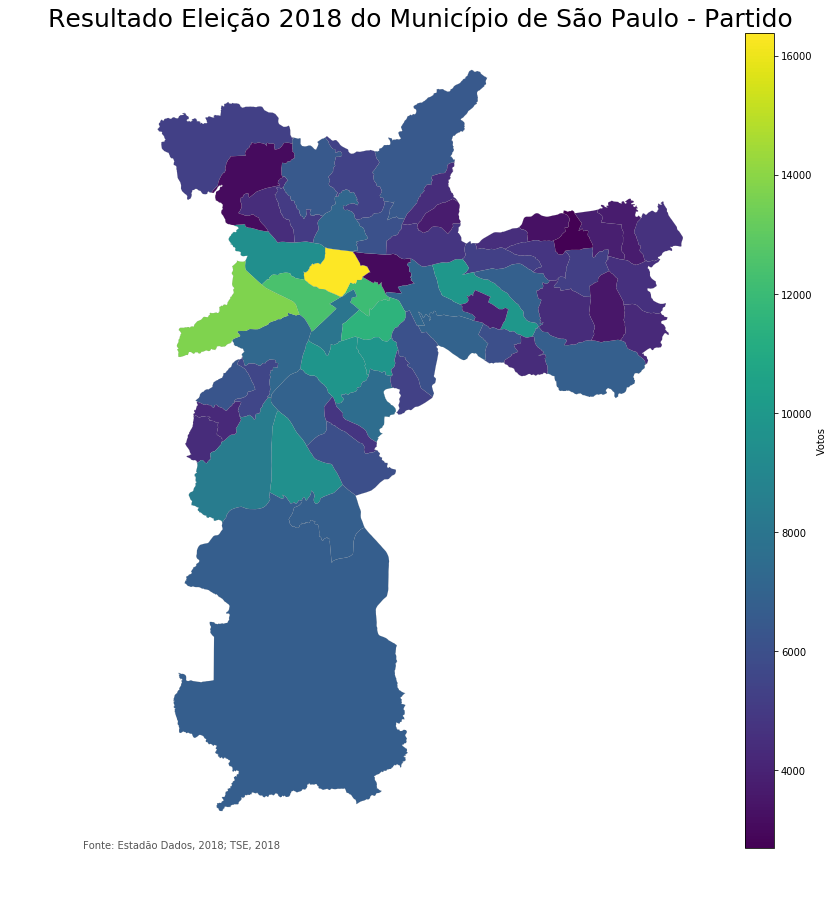

In [239]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

ax = df_mapa_part.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': 'Votos', 'orientation': 'vertical'}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')
 
ax.set_axis_off()
ax.set_title('Resultado Eleição 2018 do Município de São Paulo - Partido', fontdict={'fontsize':'25', 'fontweight':'3'})
ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.08),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')

plt.show()

In [240]:
ranking = df_mapa_part[['bairro','QT_VOTOS_NOMINAIS']].sort_values('QT_VOTOS_NOMINAIS', ascending=False)
ranking['perc'] = ranking['QT_VOTOS_NOMINAIS'] / ranking['QT_VOTOS_NOMINAIS'].sum() * 100
ranking.head()

,bairro,QT_VOTOS_NOMINAIS,perc
Name,,,
2,AGUA BRANCA,16390,4.407845
374,VILA INDIANA,13733,3.693285
251,PINHEIROS,12461,3.351200
1,BELA VISTA,12109,3.256534
6,VILA CLEMENTINO,11554,3.107275
